<img src="img/banniere.jpg" />

# Projet-10 : Détectez des faux billets avec R ou Python

- <a href="#Import"> **Imports des bibliothèques**</a>
- <a href="#analyse_D1"> **Analyse descriptive des données**</a>
    - <a href="#Imputation"> **Imputation des valeurs manquantes par régression linéaire**</a>
        - <a href='#Tests et analyses'>**Tests et analyses**</a>
            - <a href="# AAI">**Analyse des donnérs atypiques et /ou influentes**</a>
                - <a href="#Calcul_des_leviers"> Calcul des leviers</a>
                - <a href="#Calcul_residus_studentisés"> Calcul des résidus studentisés</a>
                - <a href="#Distance_de_Cook"> Distance de Cook</a>
                - <a href="#Identification_individus_influents"> Identification des individus influents</a>
            - <a href="#Colinéarité_des_variables"> Colinéarité des variables</a>
            - <a href="#Homoscédasticité"> Homoscédasticité</a>
            - <a href="#Normalité_des_residus"> Normalité des résidus</a>

            - <a href="#AnalysesV"> **Analyses et validation du modèle**</a>
            - <a href="#Tests_Residus"> **Test d'hypothèse - analyse des résidus**</a>
        - <a href="#Application_affectation"> **Appliquation du modèle et affectation**</a>
- <a href="#Analyse_D2"> **Analyse descriptive sur les données complètes**</a>
    - <a href="#Répartition_Vrai/Faux"> **Répartition Vrai/Faux billets**</a>
    - <a href ='#MesureTendanceCentrale'>Mesure de la tendance centrale</a>
    - <a href="#Mesures_de_distribution"> Mesures de distribition</a>
    - <a href="#Boxplot"> Box plot des variables en fonction de is_genuine</a>
    - <a href="#Analyse_bivariée"> **Analyse bivariée**</a>

- <a href="#Export">**Export**</a>

## <a name='Import'>Import des bibliothèques</a>

In [1]:
# Bibliothèques de base et calcul

import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import t, shapiro
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import math

# Bibliothèques de representation graphique

import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèques pour la regression lineaire

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Options globales: arrondir float pour l'output display
pd.options.display.float_format = "{:.3f}".format #leigth est en .000
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import des donnees:
billets_df = pd.read_csv("datas/billets.csv", sep = ';')          #Training set

# Séparation des données:  Création des dataframe
df_valide = billets_df.dropna() # on a beta puisque on supprime les na ==> trouver l'équation
df_na = billets_df[billets_df.isnull().any(axis=1)] # on applique l'équation pour remplacer les na

# <a name='analyse_D1'>Analyse descriptive des données</a>

In [3]:
billets_df.info()
billets_df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000,1500.000,1500.000,1463.000,1500.000,1500.000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958,104.030,103.920,4.486,3.151,112.679
std,NaN,0.305,0.299,0.326,0.664,0.232,0.873
min,NaN,171.040,103.140,102.820,2.980,2.270,109.490
25%,NaN,171.750,103.820,103.710,4.015,2.990,112.030
50%,NaN,171.960,104.040,103.920,4.310,3.140,112.960
75%,NaN,172.170,104.230,104.150,4.870,3.310,113.340


In [4]:
# On cherche les valeurs manquantes
billets_df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

**Il y a 37 valeurs manquantes pour la variable margin_low**

# <a name='Imputation'>Imputation des valeurs manquantes par regression linéaire</a>

In [5]:
# Intanciation de la régression linéaire multiple
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df_valide).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Tue, 06 Sep 2022   Prob (F-statistic):          4.75e-299
Time:                        13:35:46   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

**On applique la fonction pour trouver le model optimal par algorithme "backward"**

In [6]:
from functions_RL import *
columns = ['is_genuine','margin_low','diagonal','height_left','height_right','margin_up','length']
reg_backward = backward_selected(df_valide[columns], 'margin_low')

_______________________________
margin_low ~ length + margin_up + height_right + height_left + is_genuine + diagonal + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ margin_up + height_right + height_left + is_genuine + diagonal + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ margin_up + height_right + height_left + is_genuine + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ margin_up + height_left + is_genuine + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

**Le meilleur modele pour la régression Linéaire est : 'margin_low ~ is_genuine + margin_up + 1'**
- R² : 0.617 
- AIC: 1555.
- BIC: 1571.

In [7]:
# On fait la regression linaire (Méthode des moindres carrés)
reg_multi = smf.ols('margin_low ~ is_genuine + margin_up + 1', data=df_valide).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):          1.24e-304
Time:                        13:35:47   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

## <a name='Tests et analyses'>Tests et analyses</a>


In [8]:
# On réalise les tests à un niveau  𝛼=5 % :
alpha = 0.05

# On récvupère 𝑛, le nombre d'individus de l'échantillon, et𝑝, le nombre de variables.
n = df_valide.shape[0]
p = 4

In [9]:
X = df_valide[['is_genuine','diagonal','height_left','height_right','margin_up','length']]
# Création d'une colonne contenant les prédiction
df_valide["margin_low_pred"] = reg_multi.predict(X)
# Creation d'une colonne contenant les residus:
df_valide["residual"] = df_valide["margin_low"] - df_valide["margin_low_pred"]
df_valide

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_pred,residual
0,True,171.810,104.860,104.950,4.520,2.890,112.830,4.151,0.369
1,True,171.460,103.360,103.660,3.770,2.990,113.090,4.129,-0.359
2,True,172.690,104.480,103.500,4.400,2.940,113.160,4.140,0.260
3,True,171.360,103.910,103.940,3.620,3.010,113.510,4.125,-0.505
4,True,171.730,104.280,103.460,4.040,3.480,112.540,4.026,0.014
...,...,...,...,...,...,...,...,...,...
1495,False,171.750,104.380,104.170,4.420,3.090,111.280,5.271,-0.851
1496,False,172.190,104.630,104.440,5.270,3.370,110.970,5.212,0.058
1497,False,171.800,104.010,104.120,5.510,3.360,111.950,5.214,0.296
1498,False,172.060,104.280,104.060,5.170,3.460,112.250,5.193,-0.023


#### <a href="# AAI">Analyse des données atypiques et /ou influentes</a>

Nous allons mener des analyses sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé analyses.

In [10]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

##  <a name='Calcul_des_leviers'>Calculez les leviers</a>

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [11]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

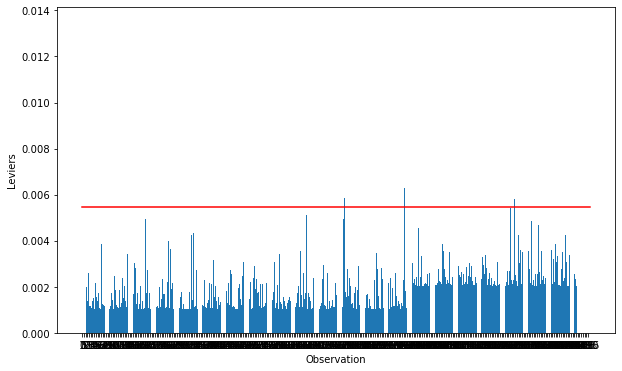

In [12]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='r')
plt.show()

In [13]:
# Pour sélectionner les points pour lesquels le levier est supérieur au seuil :
# IAI = Individus Atypique et ou Influents
iai = analyses.loc[analyses['levier'] > seuil_levier, :]
print(iai)
len(iai)

       obs  levier
48      49   0.007
52      53   0.011
123    124   0.006
376    377   0.006
649    650   0.013
655    656   0.006
774    775   0.006
779    780   0.006
952    953   0.006
1000  1001   0.008
1167  1168   0.006
1235  1236   0.005
1238  1239   0.006
1248  1249   0.005
1277  1278   0.006


15

In [14]:
# La moyenne des résidus doit être nulle et son ecart type fixé de malière déterministe
reg_multi.resid.mean()

4.503422773298379e-15

##  <a name='Calcul_residus_studentisés'>Calculez les résidus studentisés</a>
Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [15]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

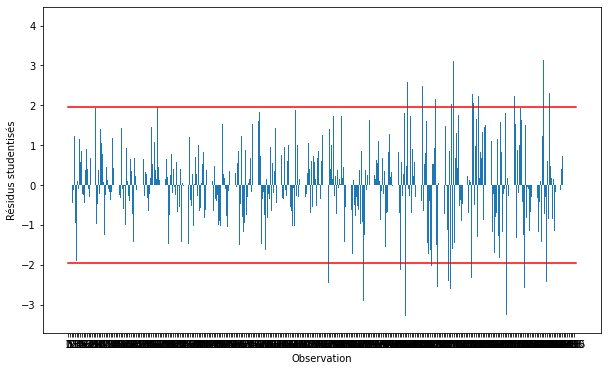

In [16]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

## <a name = 'Distance_de_Cook'>Déterminez la distance de Cook</a>
- Identification d'individus trop influents
- Pour trouver la distance de Cook :

In [17]:
influence = reg_multi.get_influence().summary_frame()

Le seuil de la distance de Cook est de n-p. 

In [18]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

### <a name="Identification_individus_influents">Identification des individus influents</a>

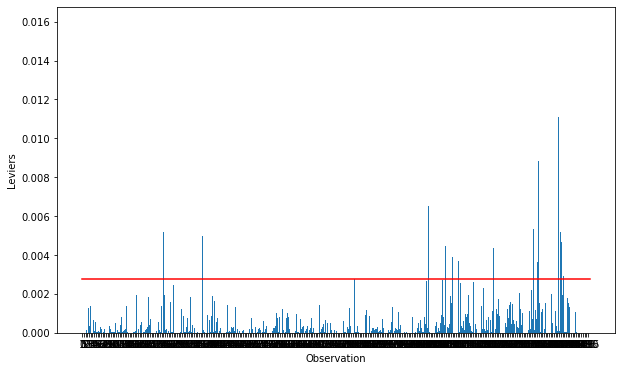

In [19]:
# On peut détecter les observations influentes comme ceci :
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1500, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

## <a name="Colinéarité_des_variables">Vérifier la colinéarité des variables</a>

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

On ne peut pas calculer le VIF car pour avoir une matrice on doit supprimer is_genuine qui est un booleen donc ile ne resterai qu'une variable explicative: margin_low

In [20]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007746]

**Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.**

## <a name='Homoscédasticité'>Testez l’homoscédasticité</a>

On peut également **tester l’homoscédasticité** (c'est-à-dire la constance de la variance) des résidus :

In [21]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.2033559115856614e-36


- La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité)nature de la variance du terme d'erreurs : si la variance est constante, alors on a de l'homoscédasticité ; en revanche, si elle varie, on a de l'hétéroscédasticité.
- **Donc L'homoscédasticité est une caractéristique d'un modèle de régression linéaire qui implique que la variance des erreurs est constante dans le temps.** 


{'Test Statistic': 166.92896597830813, 'p-value': 4.769905016347682e-35, 'F-Statistic': 46.94619855077706, 'F-Test p-value': 3.7024551237815678e-37}


Text(0.5, 1.0, 'Homoscédasticité')

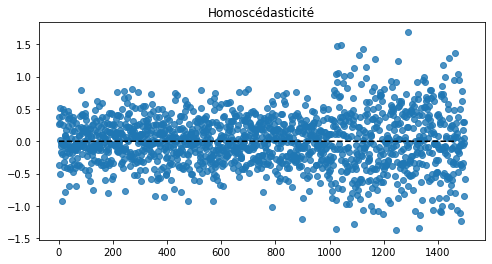

In [22]:
# Homoscedasticite:
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=df_valide.index, y=df_valide["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(df_valide.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

https://fr.wikipedia.org/wiki/Test_de_White
table khi2 : https://archimede.mat.ulaval.ca/stt1920/STT-1920-Loi-du-khi-deux.pdf
- **La répartition est aléatoire**
- **Le test de White :** 
    - H0 : L'hypothèse nulle du test de White est qu'il y a homoscédasticité 
    - H1 : Il y a hétéroscédasticité
    -  **La p-value est ici très inférieure au seuil : p-value': 4.769905016347682e-35,** on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'**homoscédasticité** de notre régression linéaire validée


## <a name='Normalité_des_residus'>Testez la normalité des résidus</a>

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [23]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 6.20942773821298e-06 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien.

La p-value du test d'Aderson-Darling vaux 4.8613414248955766e-05


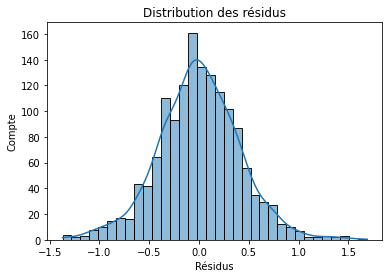

In [24]:
# Creation d'une colonne contenant les residus:
df_valide["residual"] = df_valide["margin_low"] - df_valide["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(df_valide["residual"])[1])

# Graphique:
sns.histplot(df_valide["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

In [25]:
billets_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540


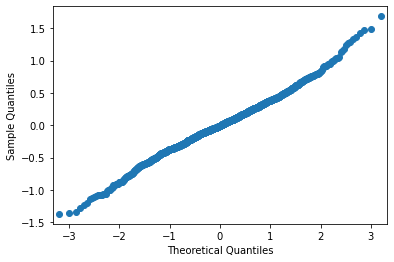

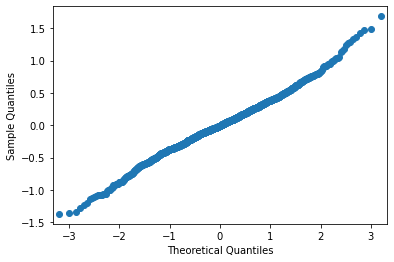

In [26]:
# qqplot
sm.qqplot(reg_multi.resid)

## <a name='AnalysesV'>Analyses et validation du modèle</a>

- Le **R²** et le **R² ajusted** : SCE du modele/SCT, sont supérieur à 5% : **0.617** et **0.616** : les variables explicatives sont pertinentes pour expliquer X 
- On test la significativité des valeurs :ici le test de student montre que les p-valeurs sont < test de 5% ==> les parametres sont significativement différents de zéro DONC les variables sont significatives pour expliquer margin_low
R² : 0.617 nous indique que les points sont dispercés autour de notre droite de régression
- **Les indicateurs de parcimonie ont été optimisés (minimiser AIC et BIC) par le choix des variables explicatives :**
    - **AIC** : Akaide information criterion : traduit la complexité du modèle par rapport a ses variable explicatives
    - **BIC** : bayesian information crterion : traduit la complexité du modèle par rapport a ses variable explicatives
- **Prob(F-Statistic) : 1.24e-304** : indique la signification globale de la régression. Il s'agit d'évaluer le niveau de signification de toutes les variables ensemble contrairement à la statistique t qui le mesure pour des variables individuelles. 
    - L'hypothèse Prob(F-statistics) représente la probabilité que l'hypothèse nulle soit vraie. Selon les résultats ci-dessus, la probabilité est proche de zéro. Cela implique que, dans l'ensemble, les régressions sont significatives.
- Les coefficients: Effet ajusté : On peut dire qu'a chaque foix que margin_up augmente de 1 point, Y augmente de -0.2119 point

## <a name="Tests_Residus">Test d'hypothèses par analyse des résidus</a>  
= erreur de prediction = residus = ÿ-y
Après avoir estimé un modèle de régression linéaire, il faut ensuite analyser :
- **Normalité de la distribution des résidus :** 
    - **Omnibus** : L'hypothèse nulle : les résidus sont distribués selon une loi Normal.
        - **Prob(Obminbus)** : devrait être proche de 1 mais dans notre cas il vaut 0.000 
    - **Caractéristiques de forme**
        - **Coefficient d'applatissement Kurtosis** : 3.793, distribution normale et leptokurtique : forme cloche
        - **Coefficient d'asymétrie Skew** : 0.057, La distribution est approximativement symetrique (entre'0.5 et0.5)
            - Une loi normale a un skew=0 et un Kurtosis=3 : proche de notre cas
                - **Prob(JB): 3.22e-09** :  sert à tester si la distribution est normale
                    -  le test s'approche alors de 0 et on accepte(ne rejette pas) Ho au seuil α : les données(les residus) suivent une loi normal
    - **Test de normalité des résidus :** 
        - **shapiro :**
            - H0 : La population est normalement distribuée
                - ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06) : 
        - si la p-value est inférieure à un niveau alpha choisi (par exemple 0.05), alors l'hypothèse nulle est rejetée (il est improbable d'obtenir de telles données en supposant qu'elles soient normalement distribuées).Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.
        
    - **Test de Durbin-Watson** :  test statistique destiné à tester l'autocorrélation des résidus dans un modèle de régression linéaire. H0 : autocorrelation si p=0 or p = 2.041 => **pas autocorrelation mais >1** ==> test de Box Pierce
- **La significativité des paramètres** : un modèle correct doit avoir des paramètres significatifs : optimisé
- **L'atypicité et l'influence éventuelle de certaines données** : on pourra retirer les données atypiques et influentes.
    - atypicité des observations : residus studentisés internes
    - influence des observations : distance de Cook
    - **Dans notre cas les valeurs atypique ne sont pas influente sur notre modèle**
- **Les éventuels problèmes de colinéarité.**
    - **Condition Number** : Cond. No. = 65.0 : N'est pas élevé ==> pas de pb de multicolinéarité
    - Le facteur d'influence des la variance multicolinéarité : 
        - indicateur VIF (pas réalisable manque de données quantitative)
        - **Pas de problème de colinéarité** : les coéfficients sont tous < 10
- **Les éventuels problèmes d'hétéroscédasticité** (quand la variance des résidus ne peut pas être considérée comme constante)
    - p-Value du test de Breusch Pagan : 3.2e-36, les variances des résidus ne sont pas constantes, alors on rejette l'hypothèse nulle d'homoscédasticité avec un risque d'erreur de 5 %
    - **Test de White** : homoscédasticité confirmé


In [27]:
X = df_na[['is_genuine','diagonal','height_left','height_right','margin_up','length']]
pred = reg_multi.predict(X)
print(pred)

72     4.074
99     4.098
151    4.123
197    3.996
241    4.123
251    4.138
284    4.078
334    4.127
410    4.102
413    4.093
445    4.125
481    4.189
505    4.131
611    4.064
654    4.191
675    4.220
710    4.112
739    4.108
742    4.076
780    4.100
798    4.125
844    4.129
845    4.148
871    4.112
895    4.131
919    4.216
945    4.123
946    4.070
981    4.129
1076   5.246
1121   5.254
1176   5.286
1303   5.305
1315   5.206
1347   5.161
1435   5.172
1438   5.240
dtype: float64


## <a name='Application_affectation'>Application du modele et affectation</a>

In [28]:
# affectation des prédictions au na du df billets_df
billets_df.loc[billets_df.margin_low.isna(),'margin_low']=pred

In [29]:
# Vérification de l'imputation par regréssion linéaire
billets_df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [30]:
billets_df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.027,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


### L'imputation des valeurs manquantes ne modifie pas de manière marquante les données dans leur ensemble

In [31]:
df_valide

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_pred,residual
0,True,171.810,104.860,104.950,4.520,2.890,112.830,4.151,0.369
1,True,171.460,103.360,103.660,3.770,2.990,113.090,4.129,-0.359
2,True,172.690,104.480,103.500,4.400,2.940,113.160,4.140,0.260
3,True,171.360,103.910,103.940,3.620,3.010,113.510,4.125,-0.505
4,True,171.730,104.280,103.460,4.040,3.480,112.540,4.026,0.014
...,...,...,...,...,...,...,...,...,...
1495,False,171.750,104.380,104.170,4.420,3.090,111.280,5.271,-0.851
1496,False,172.190,104.630,104.440,5.270,3.370,110.970,5.212,0.058
1497,False,171.800,104.010,104.120,5.510,3.360,111.950,5.214,0.296
1498,False,172.060,104.280,104.060,5.170,3.460,112.250,5.193,-0.023


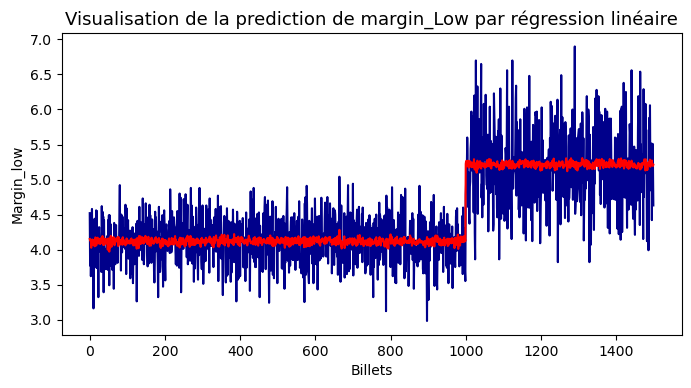

In [32]:
plt.figure(figsize=(8,4), dpi=100) 
plt.plot(df_valide["margin_low"],c='darkblue')
plt.plot(df_valide["margin_low_pred"],c='red')
plt.title("Visualisation de la prediction de margin_Low par régression linéaire",fontsize=13,loc='center')
plt.xlabel("Billets")
plt.ylabel("Margin_low")
plt.savefig('img/Visualisation de régression lineaire.png')
plt.show()

 ### Conclusion : 
- Les hypothèses du modèle de régression confirmées par notre analyse: 
    - **Linéarité** : La relation entre les variables dépendantes et indépendantes est linéaire.
    - **Homoscédasticité** : la variance constante des erreurs est maintenue.
    - **Normalité multivariée** : les résidus sont distribués normalement.
    - **Manque de multicolinéarité** : il y a pas de multicolinéarité dans les données.      

# <a name='Analyse_D2'>Analyse descriptive</a>

In [33]:
billets_df.info()
billets_df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958,104.030,103.920,4.483,3.151,112.679
std,NaN,0.305,0.299,0.326,0.660,0.232,0.873
min,NaN,171.040,103.140,102.820,2.980,2.270,109.490
25%,NaN,171.750,103.820,103.710,4.027,2.990,112.030
50%,NaN,171.960,104.040,103.920,4.310,3.140,112.960
75%,NaN,172.170,104.230,104.150,4.870,3.310,113.340


## Voir la difference entre les min/max et mean pour identifier des outliers

In [34]:
# On cherche les valeurs manquantes
billets_df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [35]:
print("Nb billet true\n" ,billets_df.loc[billets_df["is_genuine"]==True].count(),"\n")
print("Nb billet false\n" ,billets_df.loc[billets_df["is_genuine"]==False].count())

Nb billet true
 is_genuine      1000
diagonal        1000
height_left     1000
height_right    1000
margin_low      1000
margin_up       1000
length          1000
dtype: int64 

Nb billet false
 is_genuine      500
diagonal        500
height_left     500
height_right    500
margin_low      500
margin_up       500
length          500
dtype: int64


# <a name='Répartition_Vrai/Faux'>Répartition des vrais et des faux billets</a>

In [36]:
billets_df.groupby("is_genuine").count().T

is_genuine,False,True
diagonal,500,1000
height_left,500,1000
height_right,500,1000
margin_low,500,1000
margin_up,500,1000
length,500,1000


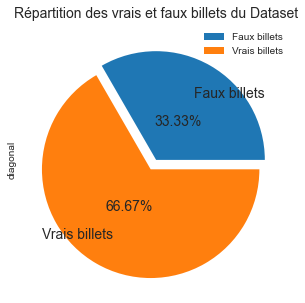

In [37]:
plt.style.use('seaborn-whitegrid')

data_genuine = billets_df.groupby("is_genuine").count()
data_genuine.plot.pie(y="diagonal",
                      figsize=(5, 5),explode = [0, 0.1],
                      labels = ["Faux billets", "Vrais billets"],
                      textprops={'fontsize':14},
                      autopct = '%1.2f%%',
                      pctdistance = 0.4, labeldistance = 0.7)
    
plt.title('Répartition des vrais et faux billets du Dataset', loc='center', fontsize=14)
plt.savefig('img/billets_repartition_vrai_faux_dfComplet.png')
plt.show()

### Au final le dataset complet contient : 
- **33,33%** : de faux billets
- **66,67%** : de faux billets
# <a name='MesureTendanceCentrale'>Mesure de la tendance centrale</a>

In [38]:
# Tendance centrale
billets_df.groupby(by="is_genuine").mean().T

is_genuine,False,True
diagonal,171.901,171.987
height_left,104.190,103.949
height_right,104.144,103.809
margin_low,5.216,4.116
margin_up,3.350,3.052
length,111.631,113.202


In [39]:
# Tendance centrale et dispersion
billets_df.groupby(by="is_genuine").median().T

is_genuine,False,True
diagonal,171.910,171.990
height_left,104.180,103.950
height_right,104.160,103.810
margin_low,5.195,4.112
margin_up,3.350,3.050
length,111.630,113.205


In [40]:
# Variance empirique. Mesurer la dispersion der la variance
billets_df.groupby(by='is_genuine').var().T

is_genuine,False,True
diagonal,0.094,0.090
height_left,0.050,0.090
height_right,0.073,0.085
margin_low,0.302,0.099
margin_up,0.033,0.035
length,0.379,0.129


Les variables concernant margin_low sont faiblement impactées

In [41]:
billets_df.groupby(by='is_genuine').var().sum()

diagonal       0.184
height_left    0.140
height_right   0.158
margin_low     0.400
margin_up      0.067
length         0.508
dtype: float64

Variance plus élevée pour les variables : margin_low (0.400) et length (0.508)

## <a name='Mesures_de_distribution'>Mesures de distribution</a>

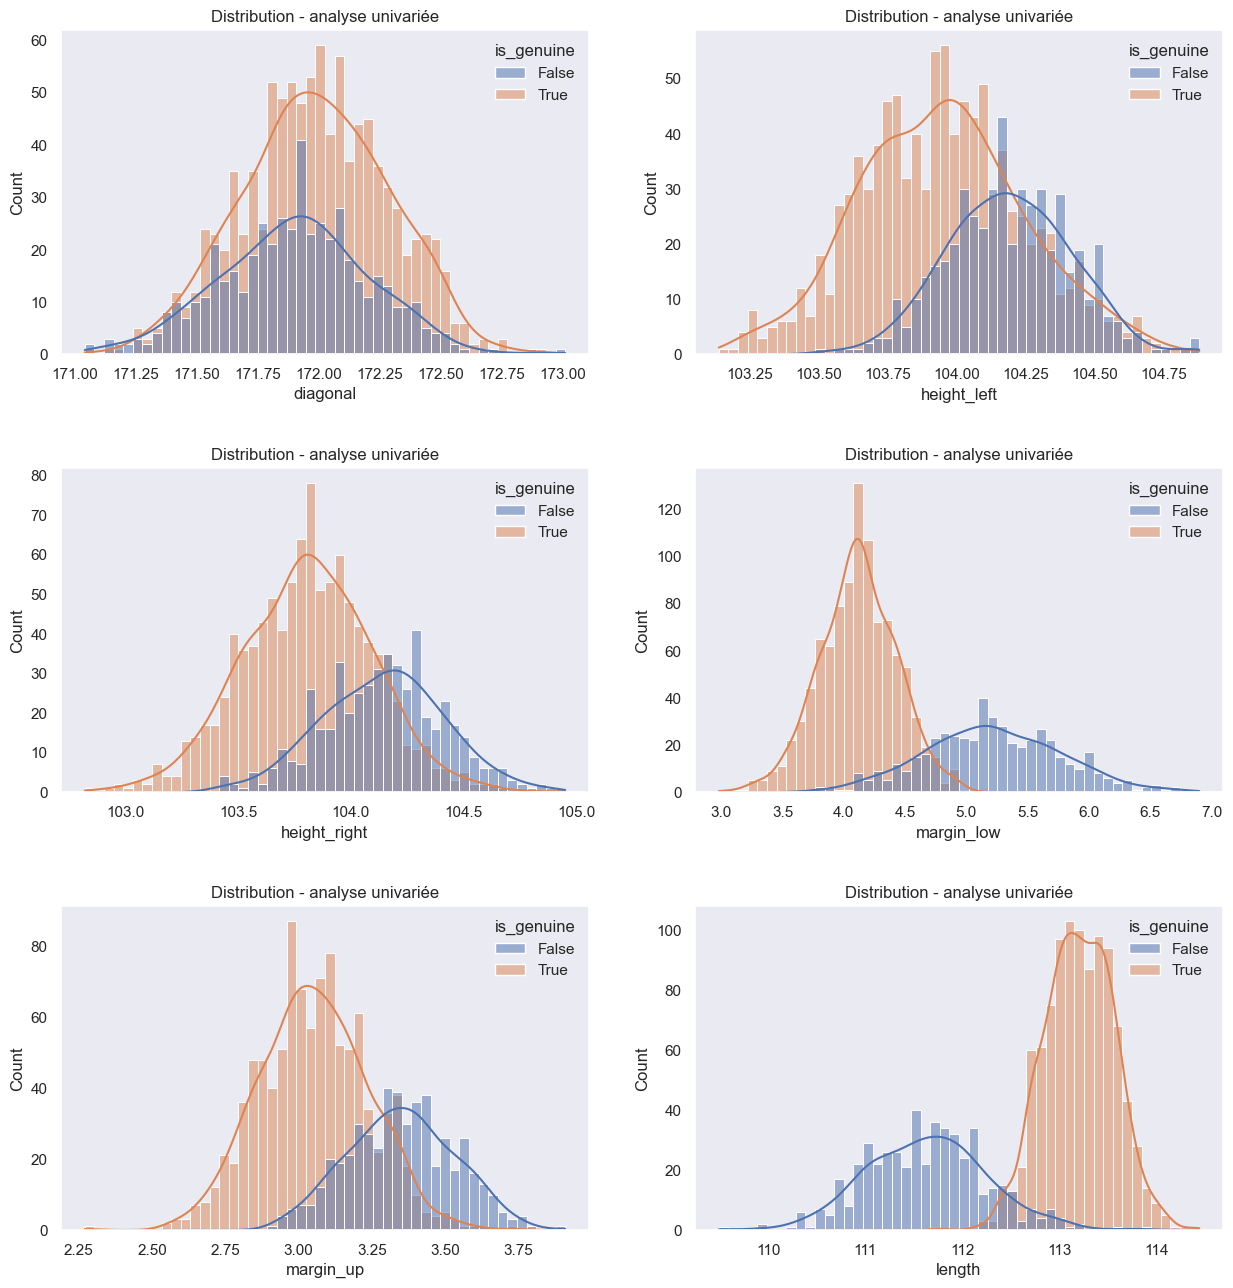

In [42]:
plt.figure(figsize=(15,15), dpi=100) # taille
sns.set(style="dark")
plt.subplot(3,2,1)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="diagonal", hue="is_genuine", bins=50, kde = True)
plt.subplot(3,2,2)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="height_left", hue="is_genuine", bins=50, kde = True)
plt.title('Distribution - analyse univariée')
plt.subplot(3,2,3)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="height_right", hue="is_genuine", bins=50, kde = True)
plt.subplot(3,2,4)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="margin_low", hue="is_genuine", bins=50, kde = True)
plt.title('Distribution - analyse univariée')
plt.subplot(3,2,5)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="margin_up", hue="is_genuine", bins=50, kde = True)
plt.subplot(3,2,6)
plt.title('Distribution - analyse univariée')
sns.histplot(data=billets_df, x="length", hue="is_genuine", bins=50, kde = True)
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.savefig('img/Analyse_univariee_distribution_dfComplet.jpg')
plt.show()

# margin_low et length sont les variables qui séparent le mieux les true des false

In [43]:
def var_hist(var, i):
    subset = billets_df[var]
    n_df_valide = len(df_valide)
    xbar = np.mean(df_valide[var]) # Moyenne
    sprime = np.std(df_valide[var], ddof=1) # Ecart-type
    sprime2 = np.var(df_valide[var], ddof=1) #Variance non biaisée
    ax = fig.add_subplot(i)
    ax.hist(subset, density=True)
    ax.axvline(xbar, color='r', linewidth=2, label="Moyenne empirique")
    bins = np.arange(df_valide[var].min(),df_valide[var].max(),0.05)
    y = st.norm.pdf(bins, xbar, sprime)
    ax.plot(bins, y, '--', label="Densité normale")
    ax.legend()
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Densité', fontsize=12)
    ax.set_title('Distribution de '+str(var), fontsize=18)

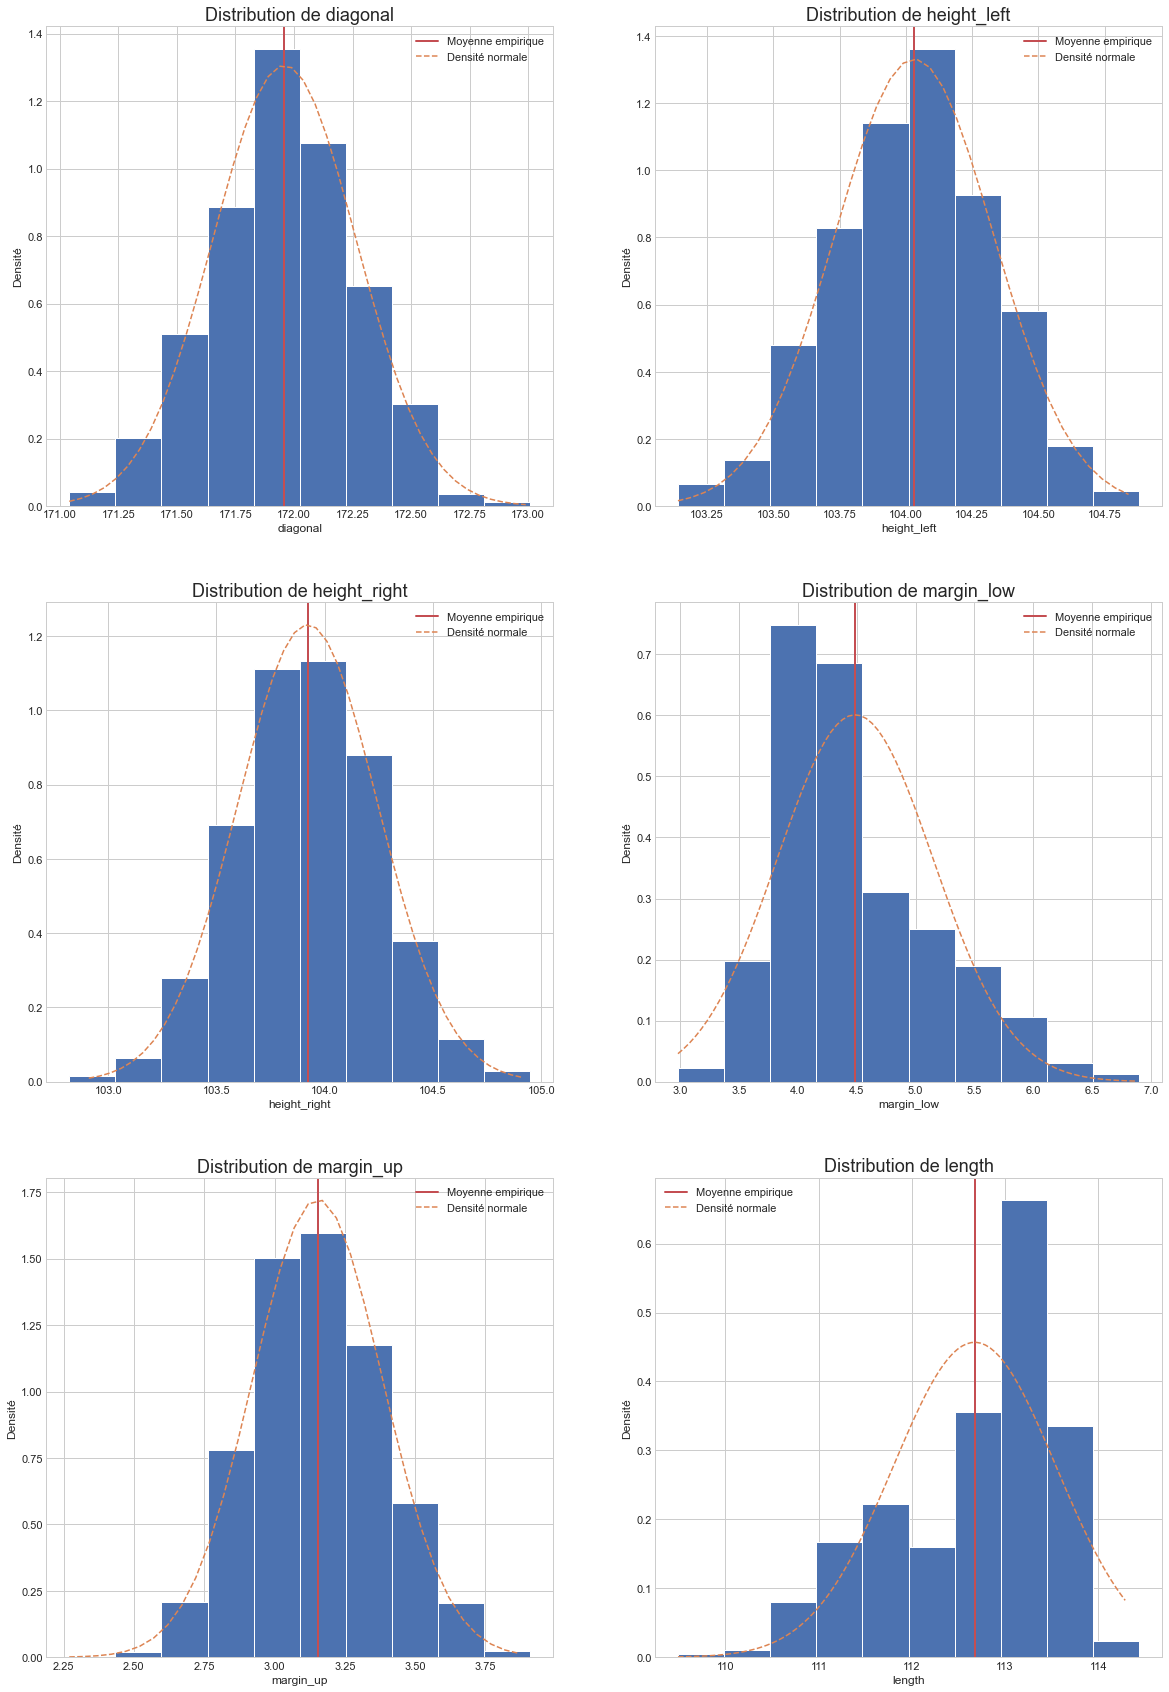

In [44]:
liste_var = ["diagonal","height_left","height_right","margin_low","margin_up","length"]
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,30),constrained_layout=False)
i = 321
for var in liste_var :
    var_hist(var, i)
    i+=1
plt.savefig("img/analyse univariee histo_dfComplet.jpg")

## L'analyse univariée montre que margin_low et length ne suivent pas exactement une loi normale

### <a name='Boxplot'>Box plot des variables en fonction de is_genuine</a>

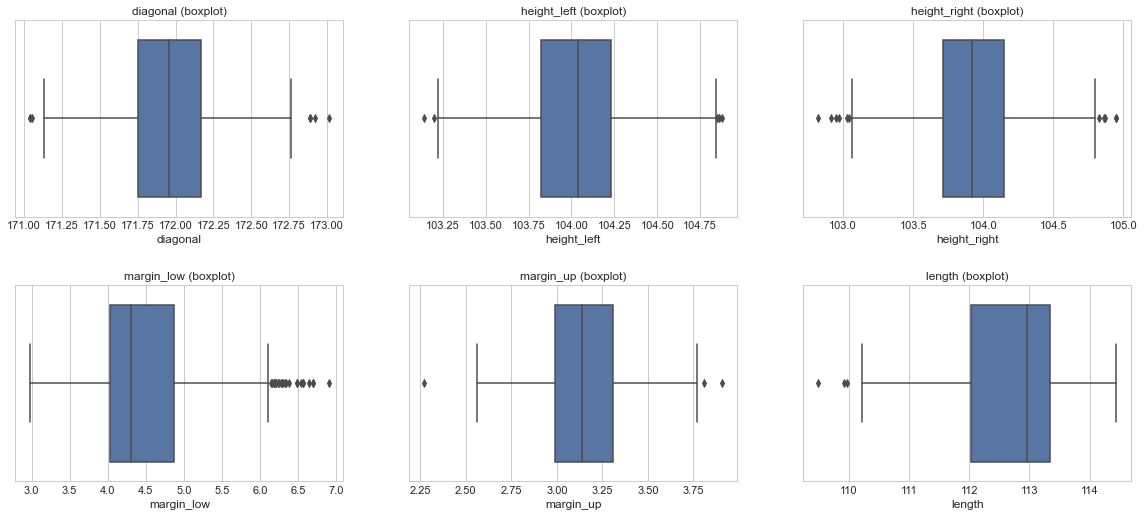

In [45]:
# Representation graphique des outliers:
a = 2  # nombre de lignes
b = 3  # nombre de colonnes
c = 1  # initialisation
fig = plt.figure(figsize=(20,8))

for i in billets_df.loc[:, billets_df.columns != "is_genuine"]: # pour toute les colonnnes quantatives
    plt.subplot(a, b, c) # maillage des subplot
    plt.title('{} (boxplot)'.format(i, a, b, c))# titres des box plot
    plt.xlabel(i) # xlabel = nom de la colonne
    sns.boxplot(x = billets_df[i]) # faire un boxplot sns
    c = c + 1 # incrementation ==> création d'un nouveau box plot
plt.subplots_adjust(left=0.125, # gerer les espacements
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)


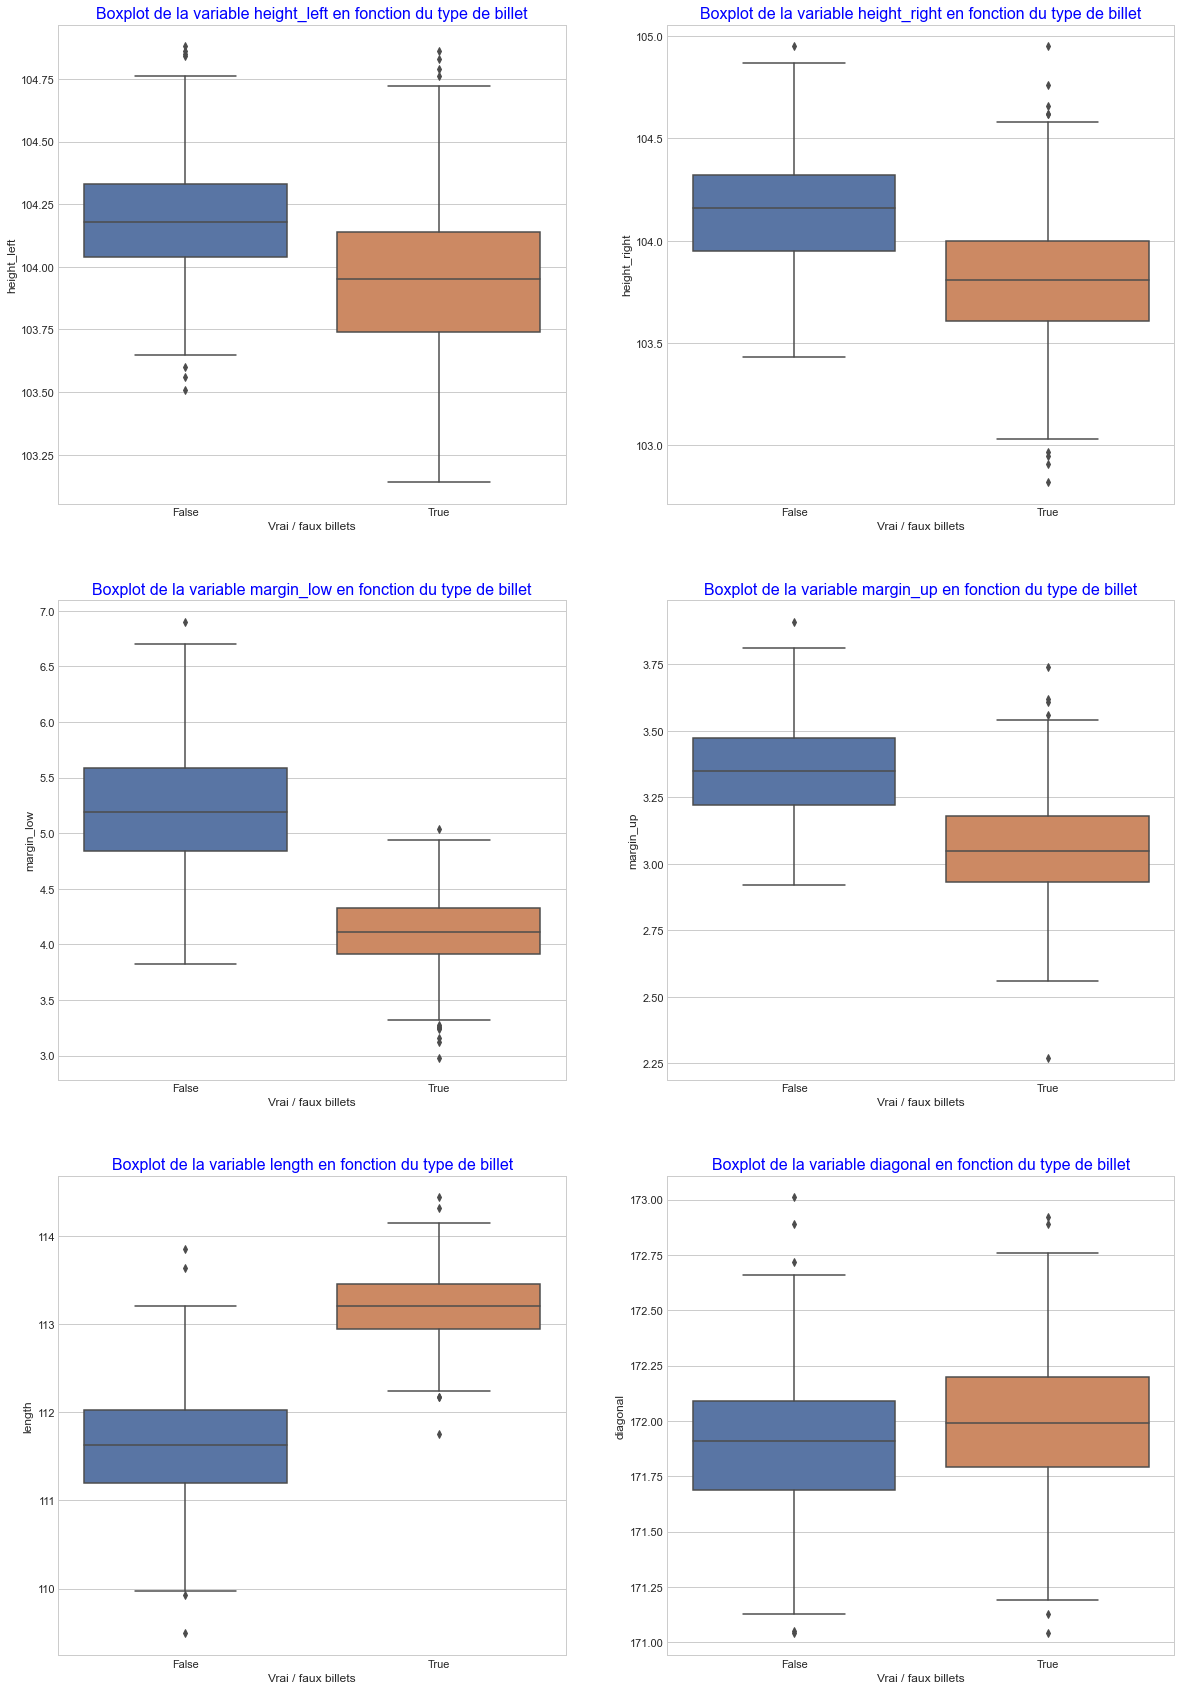

In [46]:
def var_boxplot(var, i):
    ax = fig.add_subplot(i)
    ax = sns.boxplot(x="is_genuine", y=var, data=billets_df)
    plt.xlabel('Vrai / faux billets')
    plt.ylabel(var)
    plt.title('Boxplot de la variable '+str(var)+' en fonction du type de billet', color="blue", size=16)

liste_var = ["height_left","height_right","margin_low","margin_up","length","diagonal"]

fig = plt.figure(figsize=(20,30),constrained_layout=False)
i = 321
for var in liste_var :
    var_boxplot(var, i)
    i+=1
plt.savefig("img/analyse univariee boxplot_dfComplet.jpg")

### <a name='Analyse_bivariée'>Analyse bivariée</a>

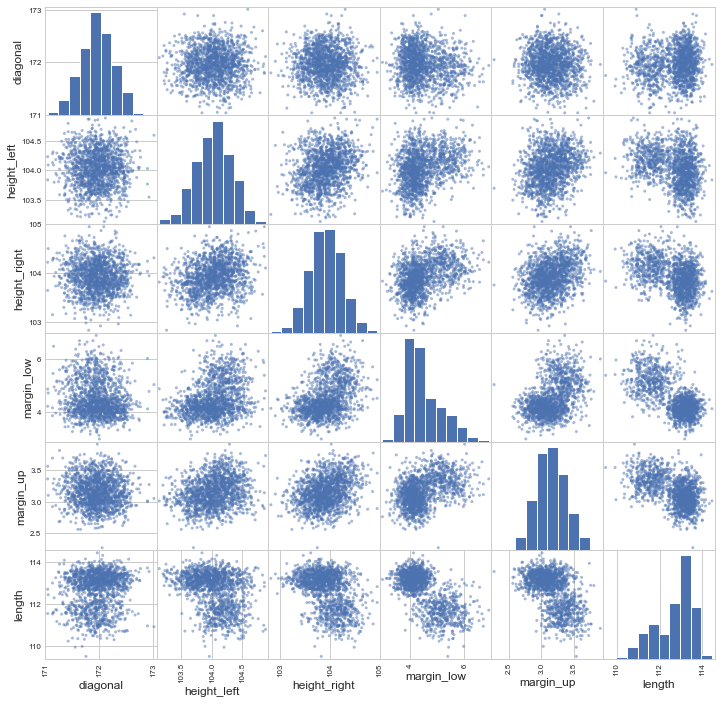

In [47]:
mycolumns = ['diagonal','height_left','height_right','margin_low','margin_up','length']
pd.plotting.scatter_matrix(billets_df[mycolumns],figsize=(12,12))
plt.savefig("img/analyse bivariee_scatter_dfComplet.jpg")

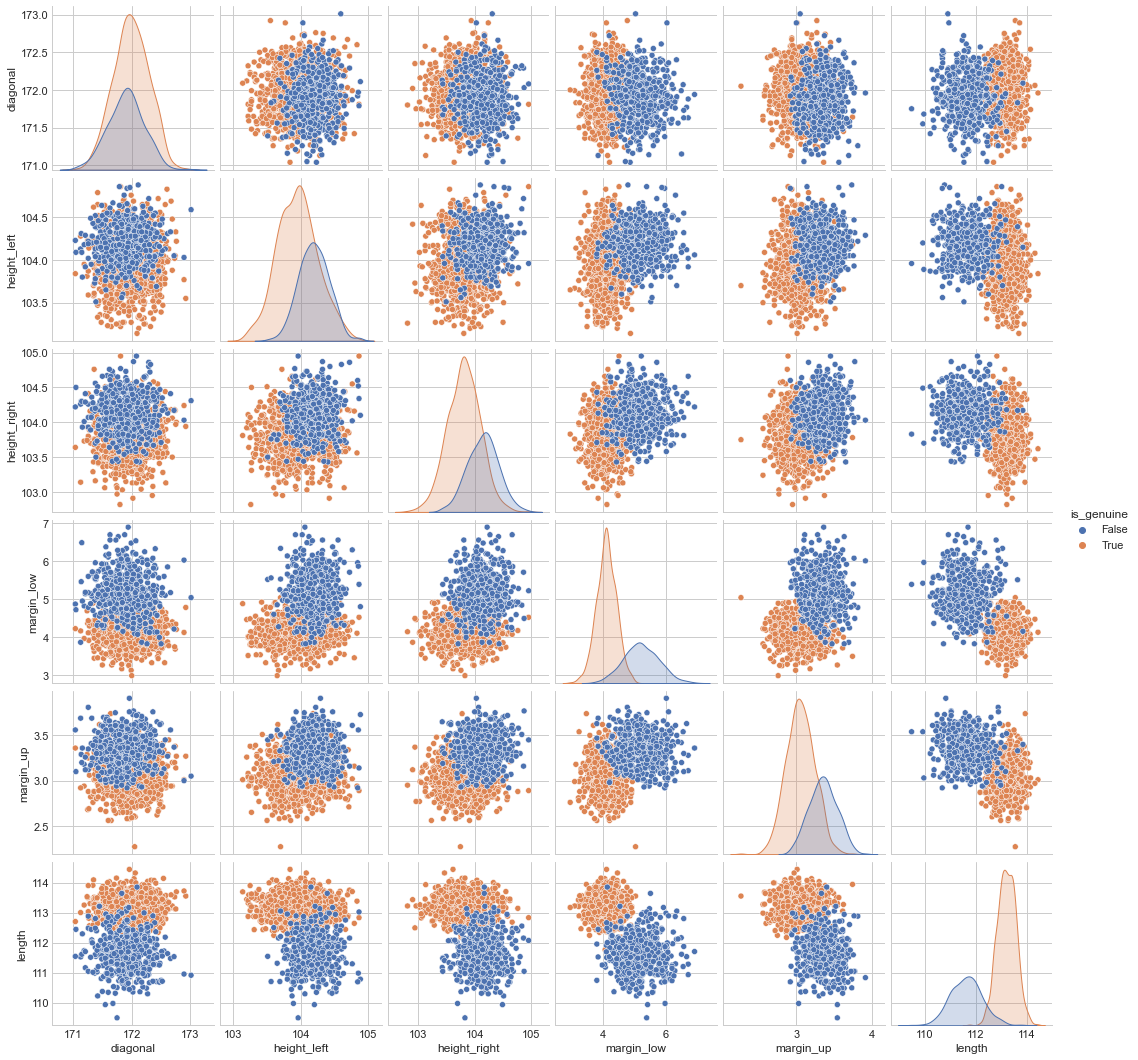

In [48]:
sns.pairplot(billets_df,hue='is_genuine',palette=None,height=2.5)
plt.savefig("img/analyse bivariee_paiplot_dfComplet.jpg")

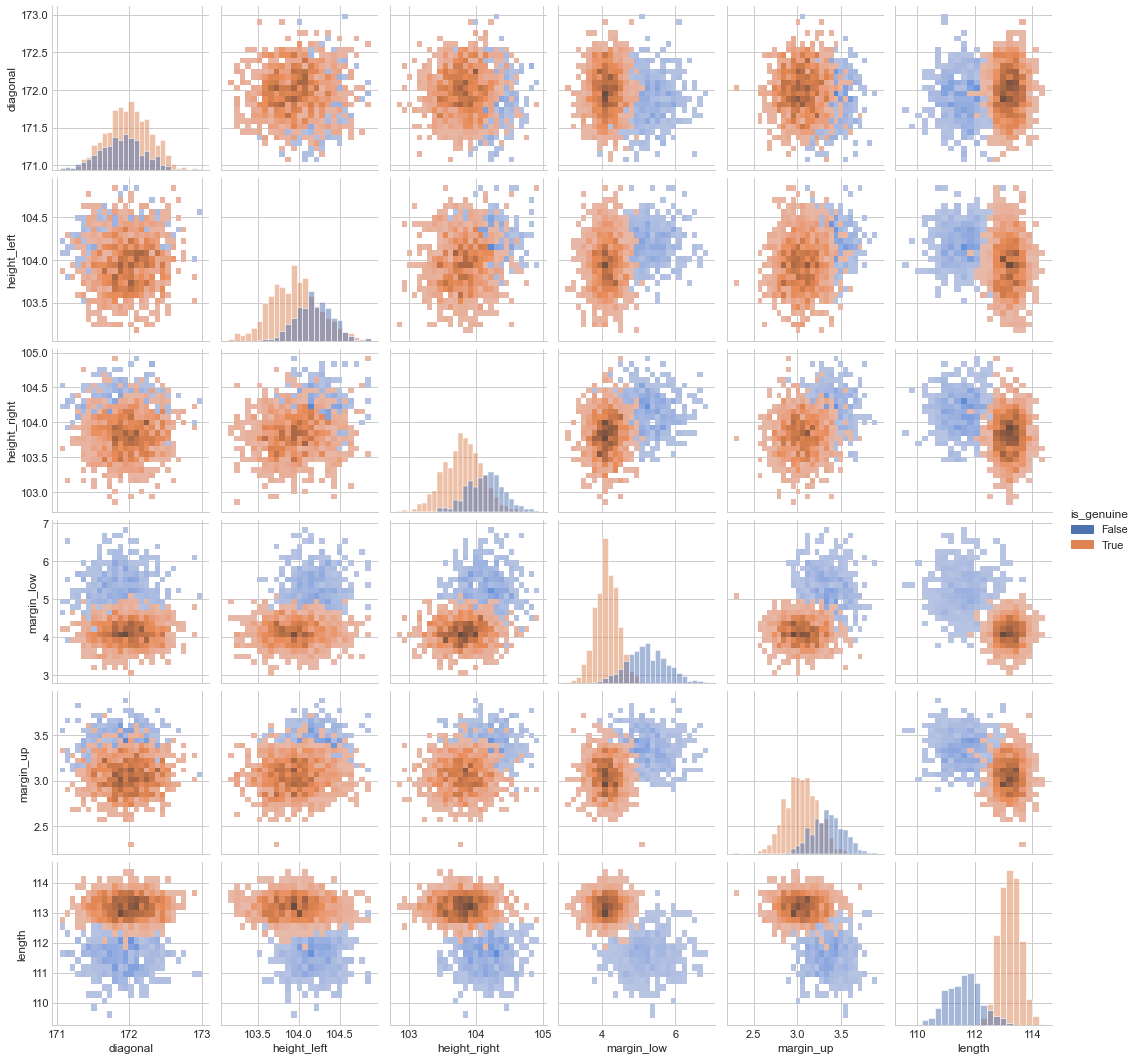

In [49]:
sns.pairplot(billets_df,hue='is_genuine',palette=None,height=2.5, kind="hist")
plt.savefig("img/analyse bivariee_pairplotHist_dfComplet.jpg")

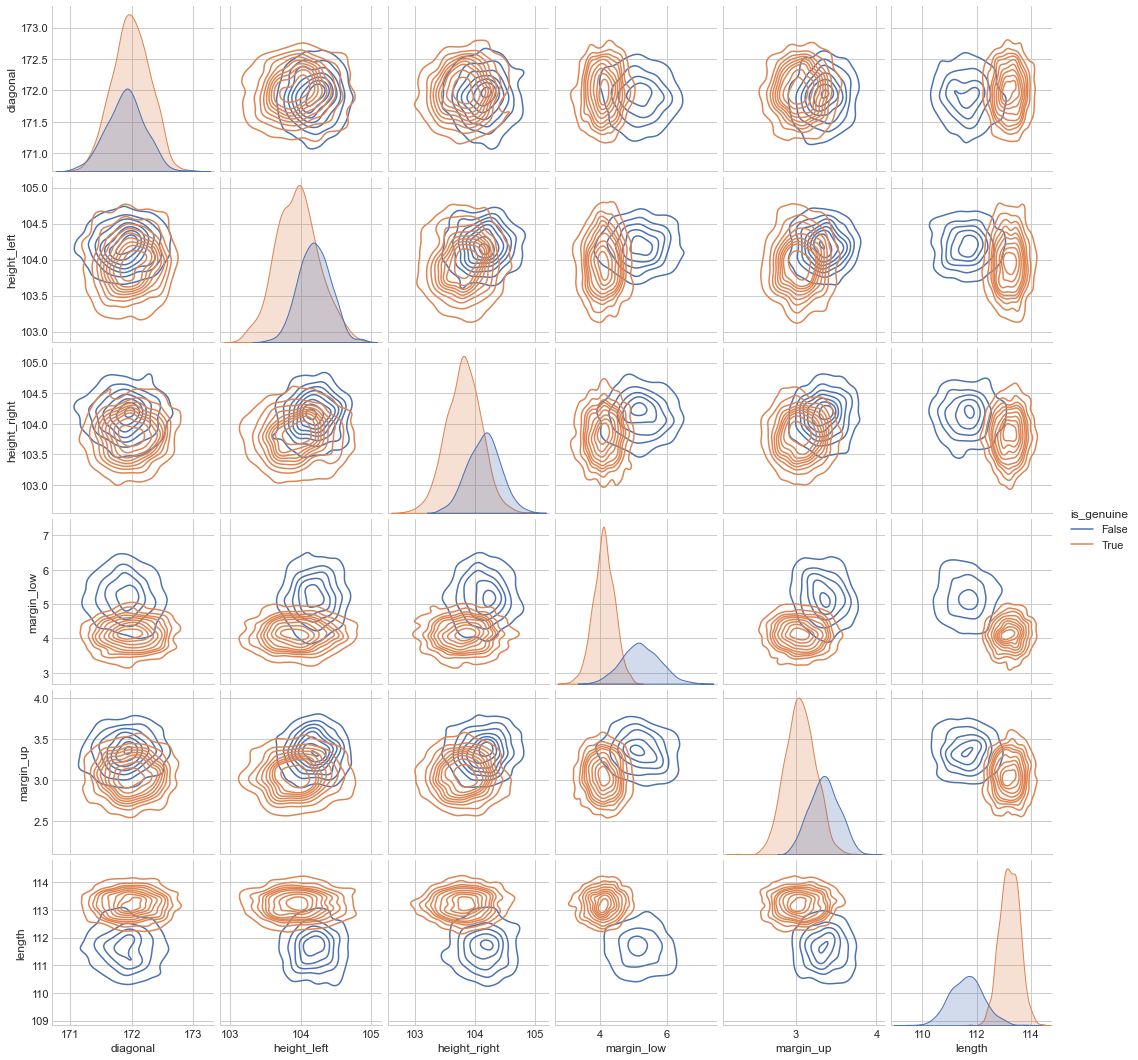

In [50]:
sns.pairplot(billets_df,hue='is_genuine',palette=None,height=2.5, kind="kde")
plt.savefig("img/analyse bivariee_pairplotKde_dfComplet.jpg")

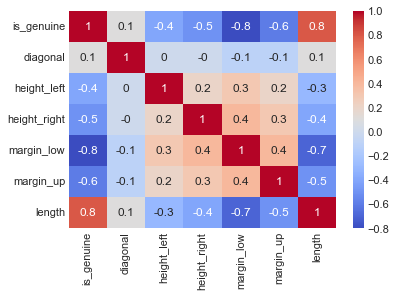

In [51]:
# Heatmap
matrice_corr = billets_df.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True,cmap='coolwarm')
plt.savefig("img/analyse bivariee_heatmap_dfComplet.jpg")

## <a name='Export'>Export et test</a>

In [52]:
# export
billets_df.to_csv('datas/billets_complet.csv',index=False)

In [53]:
# test = pd.read_csv("datas/billets_complet.csv", sep = ',')
# test